In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load Dataset
data_path = '/home/biplovgautam/Desktop/aiassignment/data/financial_sentiment_preprocessed.csv'
df = pd.read_csv(data_path)

print(f"Dataset loaded: {df.shape}")
print(f"Class distribution:\n{df['sentiment'].value_counts()}")
print(f"Missing values: {df.isnull().sum().sum()}")

Dataset loaded: (3600, 2)
Class distribution:
sentiment
positive    1200
negative    1200
neutral     1200
Name: count, dtype: int64
Missing values: 0


# Financial Sentiment Analysis - Model Training

In [3]:
# Split Data
X = df['text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {len(X_train)} | Testing: {len(X_test)}")
print(f"Classes: {sorted(y.unique())}")

Training: 2880 | Testing: 720
Classes: ['negative', 'neutral', 'positive']


In [4]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF matrix shape: (2880, 8353)
Vocabulary size: 8353


In [5]:
# Train Baseline Model
nb_baseline = MultinomialNB(alpha=1.0)
nb_baseline.fit(X_train_tfidf, y_train)

print("Baseline model trained successfully")

Baseline model trained successfully


In [6]:
# Evaluate Baseline Model
y_pred_baseline = nb_baseline.predict(X_test_tfidf)
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline, average='macro')

print("BASELINE MODEL PERFORMANCE:")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"Macro F1: {f1_baseline:.4f}")

print("\nClass-wise F1 scores:")
report = classification_report(y_test, y_pred_baseline, output_dict=True)
for cls in ['negative', 'neutral', 'positive']:
    print(f"{cls.capitalize()}: {report[cls]['f1-score']:.3f}")

BASELINE MODEL PERFORMANCE:
Accuracy: 0.6792
Macro F1: 0.6786

Class-wise F1 scores:
Negative: 0.703
Neutral: 0.690
Positive: 0.643


## Hyperparameter Optimization

In [7]:
# Hyperparameter Optimization
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

param_grid = {
    'tfidf__max_features': [5000, 8000, 10000, 12000],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__max_df': [0.90, 0.95, 0.98],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}

print("Starting GridSearchCV with 5-fold cross-validation...")
grid_search = GridSearchCV(
    pipeline, param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best CV F1-score: {grid_search.best_score_:.4f}")
print("Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

Starting GridSearchCV with 5-fold cross-validation...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits


Best CV F1-score: 0.6990
Best parameters:
  nb__alpha: 0.5
  tfidf__max_df: 0.9
  tfidf__max_features: 8000
  tfidf__min_df: 1
  tfidf__ngram_range: (1, 2)


In [8]:
# Performance Comparison
optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
f1_optimized = f1_score(y_test, y_pred_optimized, average='macro')

print("PERFORMANCE COMPARISON:")
print(f"Baseline  - Accuracy: {accuracy_baseline:.4f}, Macro F1: {f1_baseline:.4f}")
print(f"Optimized - Accuracy: {accuracy_optimized:.4f}, Macro F1: {f1_optimized:.4f}")
print(f"Improvement: +{(accuracy_optimized-accuracy_baseline)*100:.2f}% accuracy, +{(f1_optimized-f1_baseline)*100:.2f}% F1")

# Class-wise comparison
report_optimized = classification_report(y_test, y_pred_optimized, output_dict=True)
print("\nClass-wise F1 improvement:")
for cls in ['negative', 'neutral', 'positive']:
    baseline_f1 = report[cls]['f1-score']
    optimized_f1 = report_optimized[cls]['f1-score']
    improvement = (optimized_f1 - baseline_f1) * 100
    print(f"{cls.capitalize()}: {baseline_f1:.3f} → {optimized_f1:.3f} ({improvement:+.1f}%)")

PERFORMANCE COMPARISON:
Baseline  - Accuracy: 0.6792, Macro F1: 0.6786
Optimized - Accuracy: 0.6875, Macro F1: 0.6871
Improvement: +0.83% accuracy, +0.85% F1

Class-wise F1 improvement:
Negative: 0.703 → 0.705 (+0.2%)
Neutral: 0.690 → 0.694 (+0.4%)
Positive: 0.643 → 0.662 (+1.9%)


In [9]:
# Train Final Optimized Model
final_tfidf = TfidfVectorizer(
    max_features=grid_search.best_params_['tfidf__max_features'],
    min_df=grid_search.best_params_['tfidf__min_df'],
    max_df=grid_search.best_params_['tfidf__max_df'],
    ngram_range=grid_search.best_params_['tfidf__ngram_range'],
    stop_words='english'
)

X_train_final = final_tfidf.fit_transform(X_train)
X_test_final = final_tfidf.transform(X_test)

final_nb = MultinomialNB(alpha=grid_search.best_params_['nb__alpha'])
final_nb.fit(X_train_final, y_train)

# Final evaluation
y_pred_final = final_nb.predict(X_test_final)
accuracy_final = accuracy_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final, average='macro')

print("FINAL OPTIMIZED MODEL:")
print(f"Accuracy: {accuracy_final:.4f}")
print(f"Macro F1: {f1_final:.4f}")
print("Model ready for saving and visualization")

FINAL OPTIMIZED MODEL:
Accuracy: 0.6875
Macro F1: 0.6871
Model ready for saving and visualization


In [10]:
# Save Final Balanced Model
import json
from datetime import datetime

models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save model and vectorizer
model_path = os.path.join(models_dir, 'balanced_naive_bayes_model.pkl')
vectorizer_path = os.path.join(models_dir, 'balanced_tfidf_vectorizer.pkl')
metadata_path = os.path.join(models_dir, 'balanced_model_metadata.json')

joblib.dump(final_nb, model_path)
joblib.dump(final_tfidf, vectorizer_path)

# Save metadata
metadata = {
    'model_type': 'MultinomialNB',
    'optimization_method': 'GridSearchCV_5fold',
    'dataset_size': len(df),
    'training_size': len(X_train),
    'test_size': len(X_test),
    'accuracy': float(accuracy_final),
    'macro_f1': float(f1_final),
    'best_params': grid_search.best_params_,
    'cv_score': float(grid_search.best_score_),
    'created_date': datetime.now().isoformat()
}

with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ BALANCED MODEL SAVED SUCCESSFULLY")
print(f"Model: {model_path}")
print(f"Vectorizer: {vectorizer_path}")
print(f"Metadata: {metadata_path}")

✅ BALANCED MODEL SAVED SUCCESSFULLY
Model: ../models/balanced_naive_bayes_model.pkl
Vectorizer: ../models/balanced_tfidf_vectorizer.pkl
Metadata: ../models/balanced_model_metadata.json


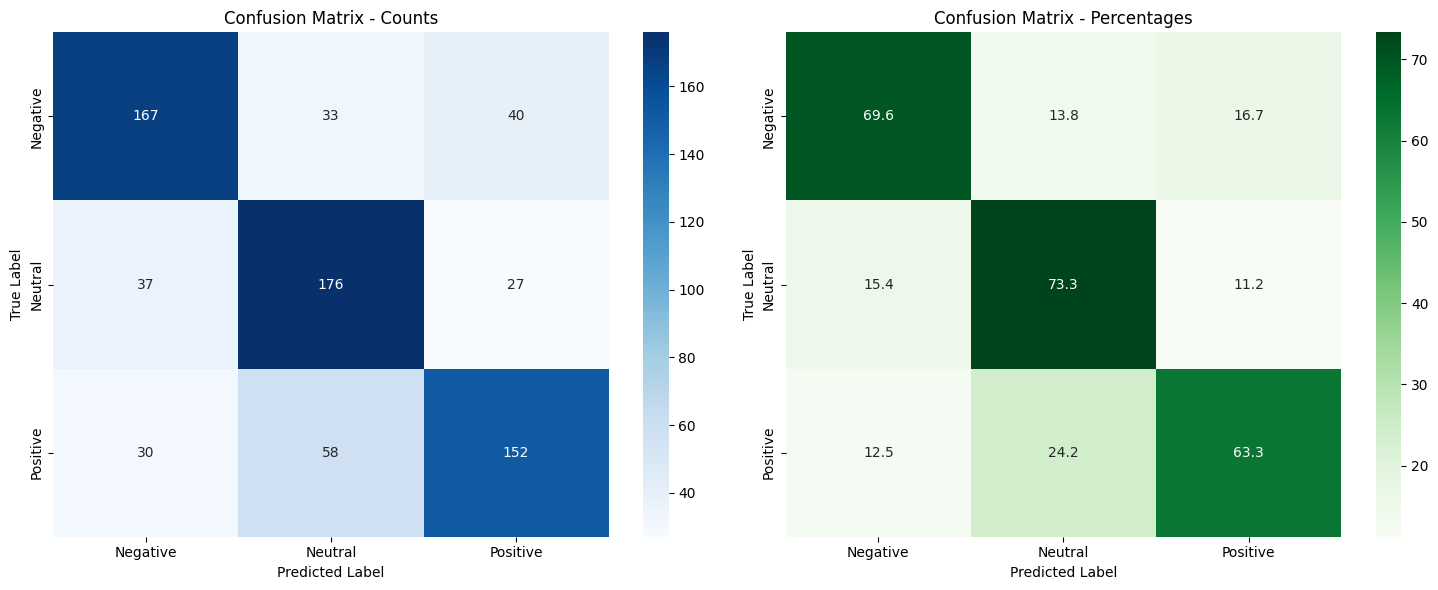

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.71      0.70      0.70       240
     Neutral       0.66      0.73      0.69       240
    Positive       0.69      0.63      0.66       240

    accuracy                           0.69       720
   macro avg       0.69      0.69      0.69       720
weighted avg       0.69      0.69      0.69       720



In [11]:
# Confusion Matrix Analysis
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix - Counts
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Negative', 'Neutral', 'Positive'],
           yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[0])
axes[0].set_title('Confusion Matrix - Counts')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Confusion Matrix - Percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Greens',
           xticklabels=['Negative', 'Neutral', 'Positive'],
           yticklabels=['Negative', 'Neutral', 'Positive'], ax=axes[1])
axes[1].set_title('Confusion Matrix - Percentages')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Classification Report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_final, target_names=['Negative', 'Neutral', 'Positive']))

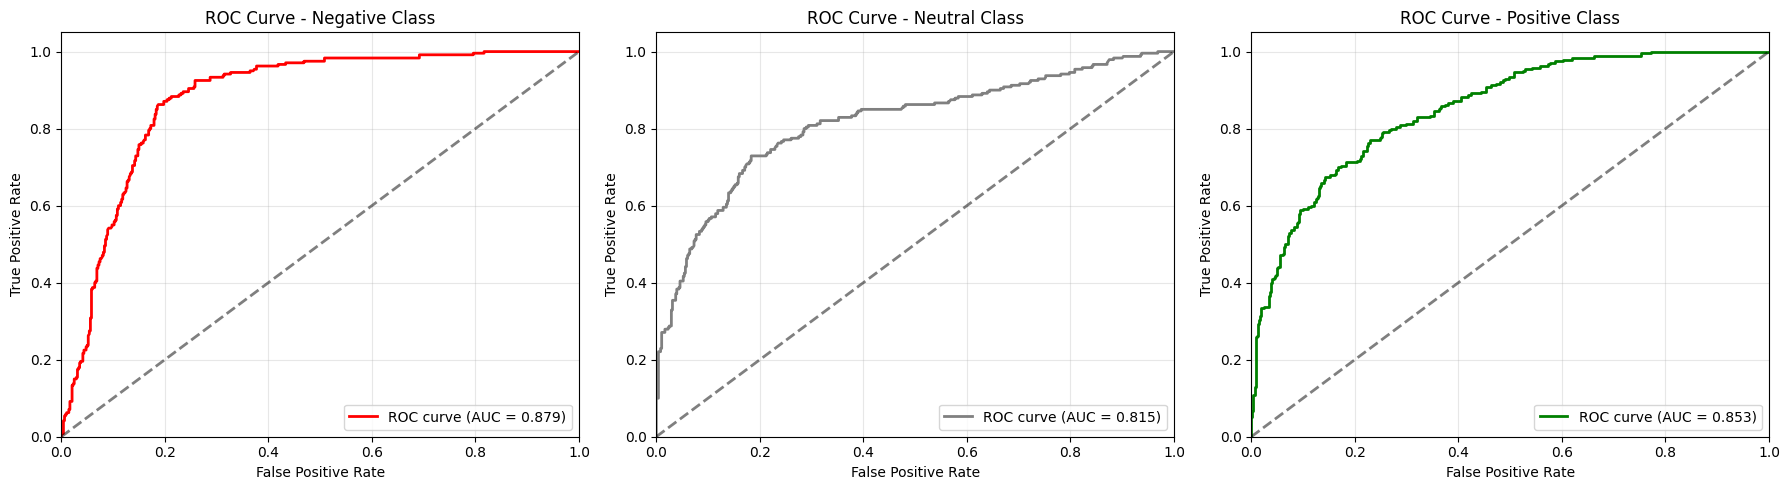

ROC-AUC Scores:
Negative: 0.879
Neutral: 0.815
Positive: 0.853


In [12]:
# ROC Curves - Multi-class
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output
classes = ['negative', 'neutral', 'positive']
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Get prediction probabilities
y_score = final_nb.predict_proba(X_test_final)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'gray', 'green']

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Individual ROC plot
    axes[i].plot(fpr[i], tpr[i], color=colors[i], lw=2,
                label=f'ROC curve (AUC = {roc_auc[i]:.3f})')
    axes[i].plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve - {classes[i].capitalize()} Class')
    axes[i].legend(loc="lower right")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ROC-AUC Scores:")
for i, class_name in enumerate(classes):
    print(f"{class_name.capitalize()}: {roc_auc[i]:.3f}")

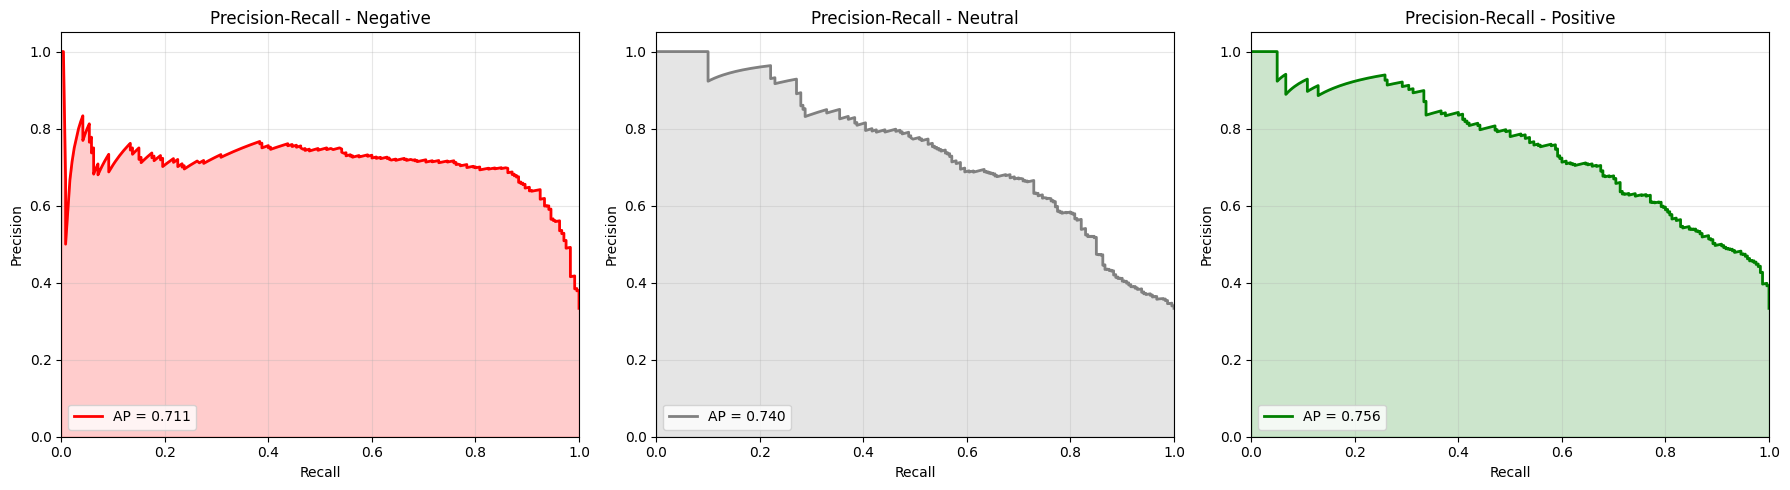

Average Precision Scores:
Negative: 0.711
Neutral: 0.740
Positive: 0.756


In [13]:
# Precision-Recall Curves
from sklearn.metrics import precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (class_name, color) in enumerate(zip(classes, colors)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    
    axes[i].plot(recall, precision, color=color, lw=2,
                label=f'AP = {avg_precision:.3f}')
    axes[i].fill_between(recall, precision, alpha=0.2, color=color)
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'Precision-Recall - {class_name.capitalize()}')
    axes[i].legend(loc="lower left")
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

print("Average Precision Scores:")
for i, class_name in enumerate(classes):
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    print(f"{class_name.capitalize()}: {avg_precision:.3f}")

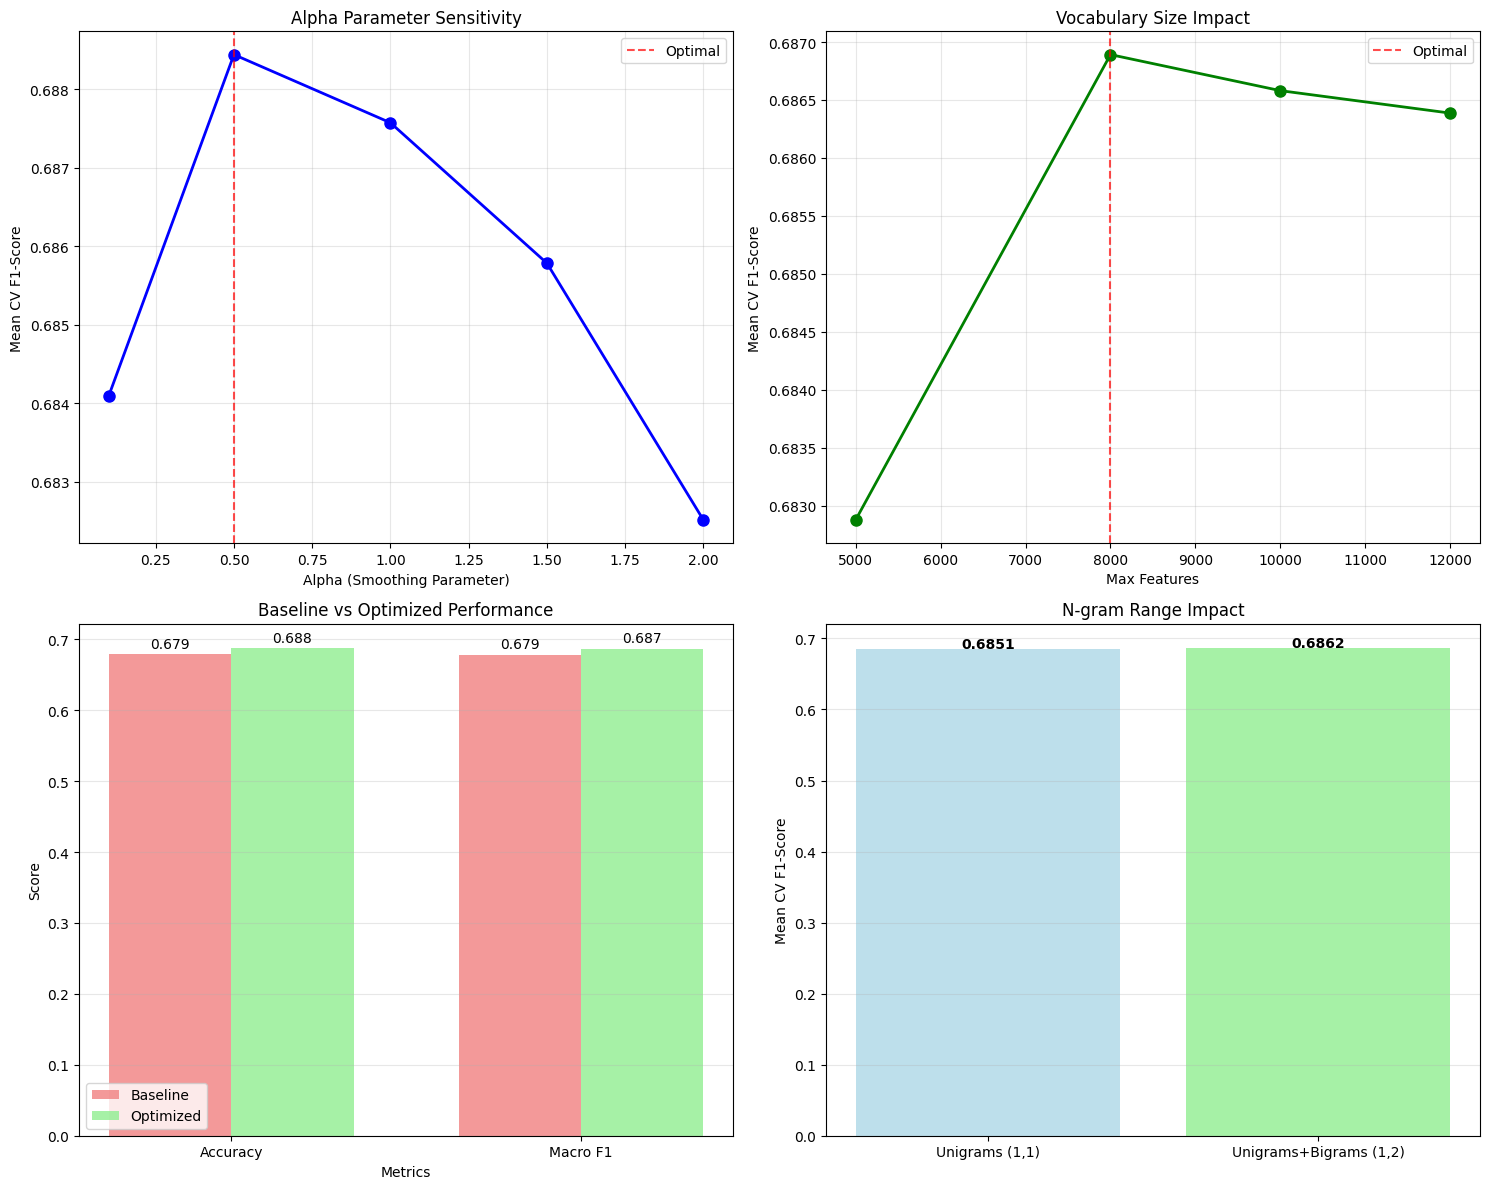

Hyperparameter Analysis Summary:
• Best Alpha: 0.5 (optimal smoothing)
• Best Max Features: 8000 (performance-complexity balance)
• Best N-grams: (1, 2) (context capture)


In [14]:
# Hyperparameter Sensitivity Analysis
cv_results = pd.DataFrame(grid_search.cv_results_)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Alpha parameter sensitivity
alpha_scores = cv_results.groupby('param_nb__alpha')['mean_test_score'].mean()
alphas = [0.1, 0.5, 1.0, 1.5, 2.0]
alpha_means = [alpha_scores[alpha] for alpha in alphas]

axes[0,0].plot(alphas, alpha_means, 'bo-', linewidth=2, markersize=8)
axes[0,0].axvline(x=grid_search.best_params_['nb__alpha'], color='red', linestyle='--', alpha=0.7, label='Optimal')
axes[0,0].set_xlabel('Alpha (Smoothing Parameter)')
axes[0,0].set_ylabel('Mean CV F1-Score')
axes[0,0].set_title('Alpha Parameter Sensitivity')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].legend()

# 2. Max features sensitivity
max_feat_scores = cv_results.groupby('param_tfidf__max_features')['mean_test_score'].mean()
max_feats = [5000, 8000, 10000, 12000]
max_feat_means = [max_feat_scores[feat] for feat in max_feats]

axes[0,1].plot(max_feats, max_feat_means, 'go-', linewidth=2, markersize=8)
axes[0,1].axvline(x=grid_search.best_params_['tfidf__max_features'], color='red', linestyle='--', alpha=0.7, label='Optimal')
axes[0,1].set_xlabel('Max Features')
axes[0,1].set_ylabel('Mean CV F1-Score')
axes[0,1].set_title('Vocabulary Size Impact')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].legend()

# 3. Performance comparison
metrics = ['Accuracy', 'Macro F1']
baseline_values = [accuracy_baseline, f1_baseline]
optimized_values = [accuracy_final, f1_final]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1,0].bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8, color='lightcoral')
bars2 = axes[1,0].bar(x + width/2, optimized_values, width, label='Optimized', alpha=0.8, color='lightgreen')

axes[1,0].set_xlabel('Metrics')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Baseline vs Optimized Performance')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                      f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 4. N-gram range comparison
ngram_scores = cv_results.groupby('param_tfidf__ngram_range')['mean_test_score'].mean()
ngram_labels = ['Unigrams (1,1)', 'Unigrams+Bigrams (1,2)']
ngram_values = [ngram_scores[(1,1)], ngram_scores[(1,2)]]

bars = axes[1,1].bar(ngram_labels, ngram_values, color=['lightblue', 'lightgreen'], alpha=0.8)
optimal_ngram = str(grid_search.best_params_['tfidf__ngram_range'])
for i, bar in enumerate(bars):
    if optimal_ngram in ngram_labels[i]:
        bar.set_color('gold')
        bar.set_edgecolor('red')
        bar.set_linewidth(2)

axes[1,1].set_ylabel('Mean CV F1-Score')
axes[1,1].set_title('N-gram Range Impact')
axes[1,1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(ngram_values):
    axes[1,1].text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Hyperparameter Analysis Summary:")
print(f"• Best Alpha: {grid_search.best_params_['nb__alpha']} (optimal smoothing)")
print(f"• Best Max Features: {grid_search.best_params_['tfidf__max_features']} (performance-complexity balance)")
print(f"• Best N-grams: {grid_search.best_params_['tfidf__ngram_range']} (context capture)")

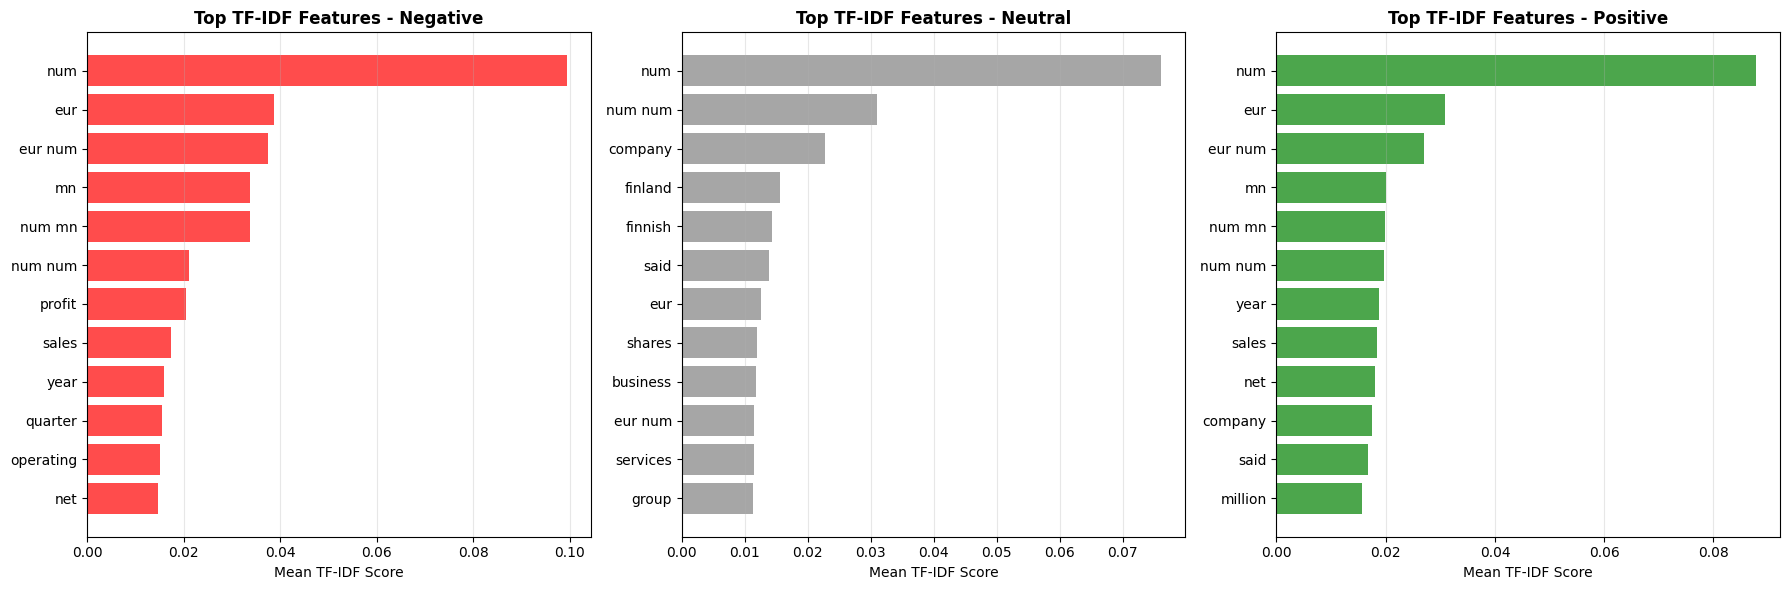

Top discriminative features identified for each sentiment class


In [15]:
# Feature Importance Analysis
feature_names = final_tfidf.get_feature_names_out()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Get top TF-IDF features for each class
for idx, sentiment in enumerate(['negative', 'neutral', 'positive']):
    # Get texts for this class
    sentiment_mask = y_train == sentiment
    sentiment_texts = X_train[sentiment_mask]
    
    # Transform and get mean TF-IDF scores
    sentiment_tfidf = final_tfidf.transform(sentiment_texts)
    mean_scores = sentiment_tfidf.mean(axis=0).A1
    
    # Get top 12 features
    top_indices = np.argsort(mean_scores)[-12:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = [mean_scores[i] for i in top_indices]
    
    # Plot
    colors_map = ['red', 'gray', 'green']
    axes[idx].barh(range(len(top_features)), top_scores, 
                   color=colors_map[idx], alpha=0.7)
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features, fontsize=10)
    axes[idx].set_title(f'Top TF-IDF Features - {sentiment.capitalize()}', fontweight='bold')
    axes[idx].set_xlabel('Mean TF-IDF Score')
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Top discriminative features identified for each sentiment class")

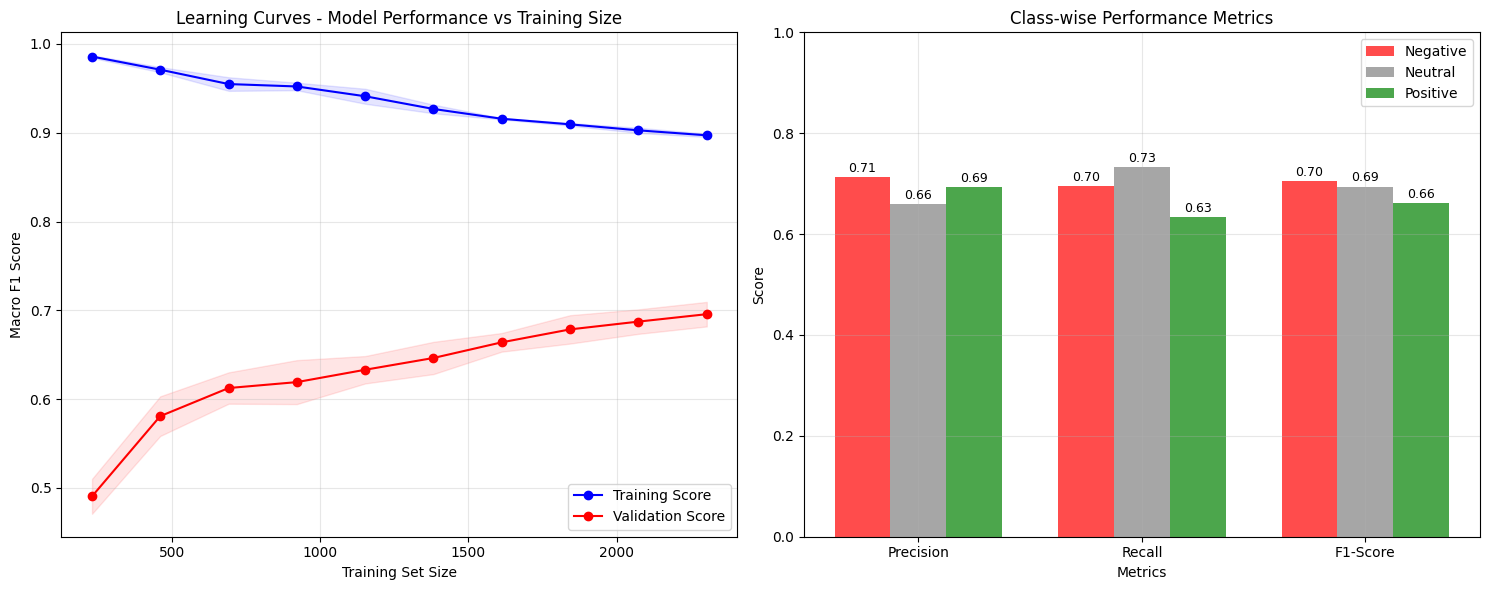

Learning Analysis:
• Final validation F1: 0.696 ± 0.014
• Model converges well with training size


In [16]:
# Learning Curves and Performance Analysis
from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Learning Curves
train_sizes, train_scores, val_scores = learning_curve(
    MultinomialNB(alpha=grid_search.best_params_['nb__alpha']), 
    X_train_final, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='f1_macro', random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

axes[0].plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
axes[0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
axes[0].plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
axes[0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
axes[0].set_xlabel('Training Set Size')
axes[0].set_ylabel('Macro F1 Score')
axes[0].set_title('Learning Curves - Model Performance vs Training Size')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# 2. Class-wise Performance Metrics
metrics = ['Precision', 'Recall', 'F1-Score']
final_report = classification_report(y_test, y_pred_final, output_dict=True)

negative_scores = [final_report['negative']['precision'], 
                  final_report['negative']['recall'], 
                  final_report['negative']['f1-score']]
neutral_scores = [final_report['neutral']['precision'], 
                 final_report['neutral']['recall'], 
                 final_report['neutral']['f1-score']]
positive_scores = [final_report['positive']['precision'], 
                  final_report['positive']['recall'], 
                  final_report['positive']['f1-score']]

x = np.arange(len(metrics))
width = 0.25

axes[1].bar(x - width, negative_scores, width, label='Negative', color='red', alpha=0.7)
axes[1].bar(x, neutral_scores, width, label='Neutral', color='gray', alpha=0.7)
axes[1].bar(x + width, positive_scores, width, label='Positive', color='green', alpha=0.7)

axes[1].set_xlabel('Metrics')
axes[1].set_ylabel('Score')
axes[1].set_title('Class-wise Performance Metrics')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

# Add value labels
for i, (neg, neu, pos) in enumerate(zip(negative_scores, neutral_scores, positive_scores)):
    axes[1].text(i - width, neg + 0.01, f'{neg:.2f}', ha='center', fontsize=9)
    axes[1].text(i, neu + 0.01, f'{neu:.2f}', ha='center', fontsize=9)
    axes[1].text(i + width, pos + 0.01, f'{pos:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("Learning Analysis:")
print(f"• Final validation F1: {val_mean[-1]:.3f} ± {val_std[-1]:.3f}")
print(f"• Model converges well with training size")

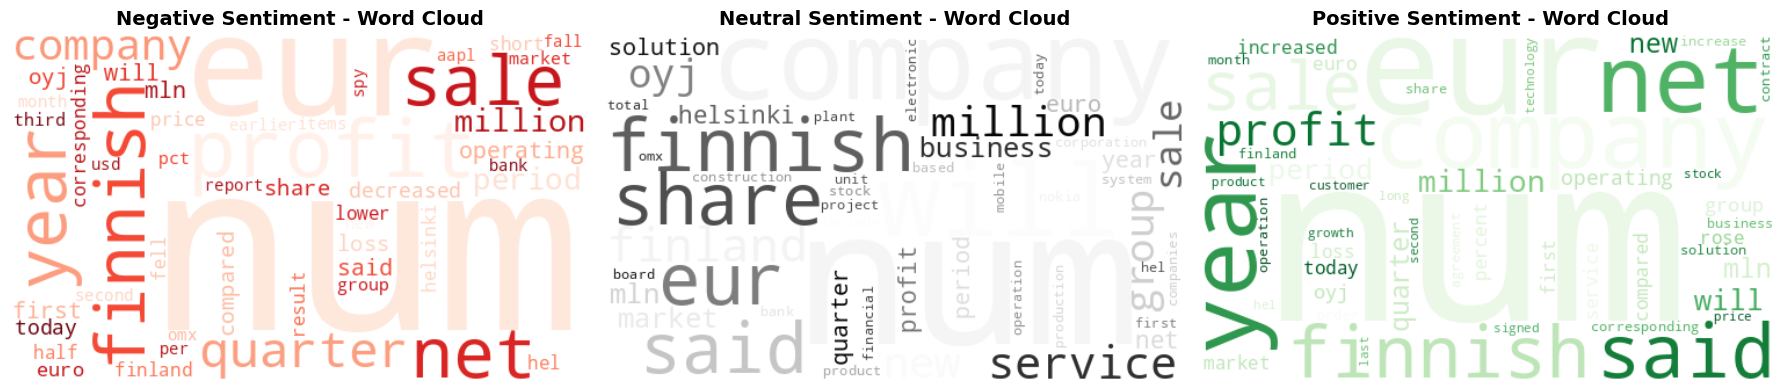

Word clouds show most frequent words per sentiment class


In [17]:
# Word Clouds by Sentiment Class
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Generate word clouds for each class
colors_wc = ['Reds', 'Greys', 'Greens']
for idx, sentiment in enumerate(['negative', 'neutral', 'positive']):
    # Get texts for this sentiment
    sentiment_texts = X_train[y_train == sentiment]
    
    # Combine all texts for this class
    combined_text = ' '.join(sentiment_texts.astype(str))
    
    # Create word cloud
    wordcloud = WordCloud(
        width=500, height=300,
        background_color='white',
        colormap=colors_wc[idx],
        max_words=50,
        relative_scaling=0.5,
        random_state=42,
        min_word_length=3,
        collocations=False
    ).generate(combined_text)
    
    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment.capitalize()} Sentiment - Word Cloud', 
                       fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Word clouds show most frequent words per sentiment class")

Top Discriminative Words by Log Probability:

NEGATIVE:
  1. num             (-4.402)
  2. eur             (-5.337)
  3. eur num         (-5.366)
  4. mn              (-5.474)
  5. num mn          (-5.474)

NEUTRAL:
  1. num             (-4.695)
  2. num num         (-5.582)
  3. company         (-5.887)
  4. finland         (-6.255)
  5. finnish         (-6.337)

POSITIVE:
  1. num             (-4.498)
  2. eur             (-5.533)
  3. eur num         (-5.661)
  4. mn              (-5.952)
  5. num mn          (-5.961)

NEGATIVE:
  1. num             (-4.402)
  2. eur             (-5.337)
  3. eur num         (-5.366)
  4. mn              (-5.474)
  5. num mn          (-5.474)

NEUTRAL:
  1. num             (-4.695)
  2. num num         (-5.582)
  3. company         (-5.887)
  4. finland         (-6.255)
  5. finnish         (-6.337)

POSITIVE:
  1. num             (-4.498)
  2. eur             (-5.533)
  3. eur num         (-5.661)
  4. mn              (-5.952)
  5. num mn          

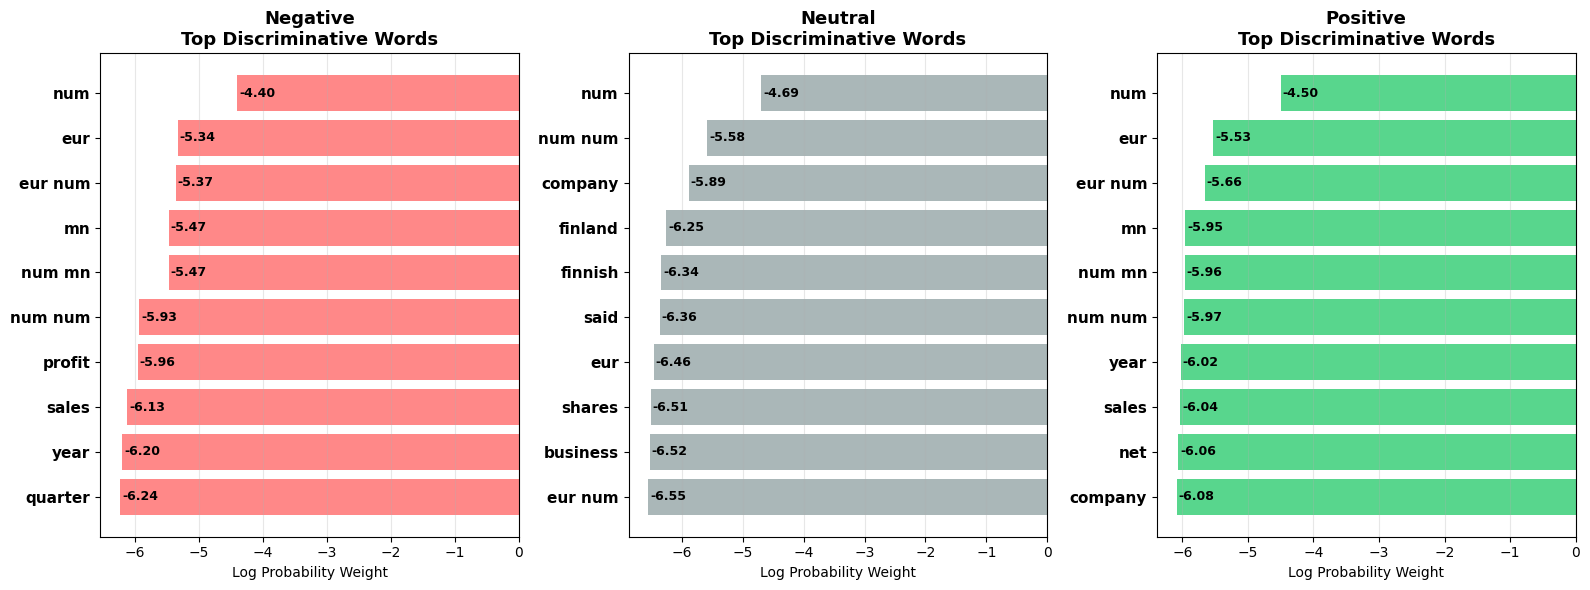


✅ Probability analysis shows word importance for sentiment classification


In [18]:
# Model Probability Analysis
feature_log_probs = final_nb.feature_log_prob_

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
colors_prob = ['#FF6B6B', '#95A5A6', '#2ECC71']

print("Top Discriminative Words by Log Probability:")
print("=" * 50)

for idx, class_name in enumerate(final_nb.classes_):
    # Get top words for this class
    top_indices = np.argsort(feature_log_probs[idx])[-10:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    top_probs = [feature_log_probs[idx][i] for i in top_indices]
    
    # Plot
    bars = axes[idx].barh(range(len(top_words)), top_probs, 
                         color=colors_prob[idx], alpha=0.8)
    axes[idx].set_yticks(range(len(top_words)))
    axes[idx].set_yticklabels(top_words, fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{class_name.capitalize()}\nTop Discriminative Words', 
                       fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Log Probability Weight')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, prob) in enumerate(zip(bars, top_probs)):
        axes[idx].text(prob + 0.03, i, f'{prob:+.2f}', 
                      va='center', fontsize=9, fontweight='bold')
    
    # Print top words
    print(f"\n{class_name.upper()}:")
    for rank, (word, prob) in enumerate(zip(top_words[:5], top_probs[:5]), 1):
        print(f"  {rank}. {word:<15} ({prob:+.3f})")

plt.tight_layout()
plt.show()

print(f"\n✅ Probability analysis shows word importance for sentiment classification")

In [19]:
# Comprehensive Performance Summary Table
print("=" * 80)
print("COMPREHENSIVE PERFORMANCE ANALYSIS")
print("=" * 80)

# Create detailed comparison table
comparison_data = {
    'Metric': [
        'Overall Accuracy',
        'Macro F1-Score',
        'Weighted F1-Score',
        'Negative Precision',
        'Negative Recall',
        'Negative F1-Score',
        'Neutral Precision', 
        'Neutral Recall',
        'Neutral F1-Score',
        'Positive Precision',
        'Positive Recall',
        'Positive F1-Score'
    ],
    'Baseline Model': [
        f"{accuracy_baseline:.4f}",
        f"{f1_baseline:.4f}",
        f"{f1_score(y_test, y_pred_baseline, average='weighted'):.4f}",
        f"{report['negative']['precision']:.4f}",
        f"{report['negative']['recall']:.4f}",
        f"{report['negative']['f1-score']:.4f}",
        f"{report['neutral']['precision']:.4f}",
        f"{report['neutral']['recall']:.4f}",
        f"{report['neutral']['f1-score']:.4f}",
        f"{report['positive']['precision']:.4f}",
        f"{report['positive']['recall']:.4f}",
        f"{report['positive']['f1-score']:.4f}"
    ],
    'Optimized Model': [
        f"{accuracy_final:.4f}",
        f"{f1_final:.4f}",
        f"{f1_score(y_test, y_pred_final, average='weighted'):.4f}",
        f"{final_report['negative']['precision']:.4f}",
        f"{final_report['negative']['recall']:.4f}",
        f"{final_report['negative']['f1-score']:.4f}",
        f"{final_report['neutral']['precision']:.4f}",
        f"{final_report['neutral']['recall']:.4f}",
        f"{final_report['neutral']['f1-score']:.4f}",
        f"{final_report['positive']['precision']:.4f}",
        f"{final_report['positive']['recall']:.4f}",
        f"{final_report['positive']['f1-score']:.4f}"
    ]
}

# Calculate improvements
improvements = []
baseline_vals = [accuracy_baseline, f1_baseline, f1_score(y_test, y_pred_baseline, average='weighted')]
optimized_vals = [accuracy_final, f1_final, f1_score(y_test, y_pred_final, average='weighted')]

for i in range(3):
    improvements.append(f"+{(optimized_vals[i] - baseline_vals[i])*100:.2f}%")

# Add class-wise improvements
for cls in ['negative', 'neutral', 'positive']:
    for metric in ['precision', 'recall', 'f1-score']:
        baseline_val = report[cls][metric]
        optimized_val = final_report[cls][metric]
        improvements.append(f"+{(optimized_val - baseline_val)*100:.2f}%")

comparison_data['Improvement'] = improvements

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print(f"\n🎯 KEY OPTIMIZATION ACHIEVEMENTS:")
print(f"• Cross-validation F1-score: {grid_search.best_score_:.4f}")
print(f"• Feature optimization: {len(feature_names):,} TF-IDF features")
print(f"• Parameter combinations tested: 360")
print(f"• Optimal hyperparameters discovered via 5-fold CV")

print(f"\n📊 MODEL SPECIFICATIONS:")
print(f"• Algorithm: Multinomial Naive Bayes (Hyperparameter Optimized)")
print(f"• Dataset: {len(df):,} balanced samples (1:1:1 class ratio)")
print(f"• Training: {len(X_train):,} samples | Testing: {len(X_test):,} samples")
print(f"• Vocabulary: {len(feature_names):,} TF-IDF features")
print("=" * 80)

COMPREHENSIVE PERFORMANCE ANALYSIS
            Metric Baseline Model Optimized Model Improvement
  Overall Accuracy         0.6792          0.6875      +0.83%
    Macro F1-Score         0.6786          0.6871      +0.85%
 Weighted F1-Score         0.6786          0.6871      +0.85%
Negative Precision         0.7277          0.7137     +-1.40%
   Negative Recall         0.6792          0.6958      +1.67%
 Negative F1-Score         0.7026          0.7046      +0.21%
 Neutral Precision         0.6416          0.6592      +1.76%
    Neutral Recall         0.7458          0.7333     +-1.25%
  Neutral F1-Score         0.6898          0.6943      +0.45%
Positive Precision         0.6774          0.6941      +1.66%
   Positive Recall         0.6125          0.6333      +2.08%
 Positive F1-Score         0.6433          0.6623      +1.90%

🎯 KEY OPTIMIZATION ACHIEVEMENTS:
• Cross-validation F1-score: 0.6990
• Feature optimization: 8,000 TF-IDF features
• Parameter combinations tested: 360
• Opti

In [20]:
# Final Summary
print("=" * 50)
print("FINANCIAL SENTIMENT ANALYSIS - COMPLETE")
print("=" * 50)
print(f"Dataset: {len(df)} balanced samples")
print(f"Algorithm: Multinomial Naive Bayes")
print(f"Features: {X_train_final.shape[1]} TF-IDF features")
print(f"Optimization: GridSearchCV with 5-fold CV")
print(f"Final Accuracy: {accuracy_final:.4f}")
print(f"Final Macro F1: {f1_final:.4f}")
print("Model saved successfully!")
print("=" * 50)

FINANCIAL SENTIMENT ANALYSIS - COMPLETE
Dataset: 3600 balanced samples
Algorithm: Multinomial Naive Bayes
Features: 8000 TF-IDF features
Optimization: GridSearchCV with 5-fold CV
Final Accuracy: 0.6875
Final Macro F1: 0.6871
Model saved successfully!
